# Load and crop image

In [5]:
import cv2
import numpy as np
from dataclasses import dataclass

image = cv2.imread('../img/4.jpg')


@dataclass
class Cropper:
    
    x_start: float = None
    y_start: float = None
    x_end: float = None
    y_end: float = None
    cropping: bool = False
    original_image: np.ndarray = None
    cropped_image: np.ndarray = None
    
    def _mouse_crop(self, event: int, x: float, y: float, *args, **kwargs):
        # if the left mouse button was DOWN, start recording
        if event == cv2.EVENT_LBUTTONDOWN:
            self._start_cropping(x, y)
        
        # if the left mouse button was released, finish recording and display final crop
        elif event == cv2.EVENT_LBUTTONUP:
            # record the ending (x, y) coordinates
            self._finish_cropping(x, y)
            self._show_crop()
                
    def _start_cropping(self, x: float, y: float):
        self.x_start, self.y_start = x, y
        self.cropping = True
        
    def _finish_cropping(self, x: float, y: float):
        self.x_end, self.y_end = x, y
        self.cropping = False # cropping is finished
        
    def _show_crop(self):
        refPoint = [(self.x_start, self.y_start), (self.x_end, self.y_end)]
        roi = self.original_image[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        cv2.imshow("Cropped", roi)
        self.cropped_image = roi
        
    def crop_image(self, image: np.ndarray):
        self.original_image = image.copy()
        cv2.namedWindow("image")
        cv2.setMouseCallback("image", self._mouse_crop)
        cv2.imshow("image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
cropper = Cropper()
cropper.crop_image(image)

# OCR on cropped image

6 WING PLATE 020108870398 — 3.98 P
ASST 27 063099656595 4.88 X
CUTIE CAR 063099656644 12.88 X



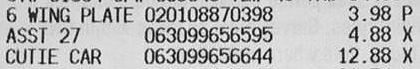

In [6]:
from PIL import Image
import pytesseract

alternate_psm = False  # This should be False by default, usually OCR works better for receipts with psm=4

psm = 6 if alternate_psm else 4

cropped_image = Image.fromarray(cropper.cropped_image)
parsed_text = pytesseract.image_to_string(cropped_image, config=fr'-l eng --psm {psm}')

print(parsed_text)
cropped_image

# Manually fix parsed text

In [7]:
import ipywidgets as widgets


textfield = widgets.Textarea(
    value=parsed_text,
    placeholder='Type something',
    description='Parsed text:',
    layout={'width': '100%'}
)
textfield

Textarea(value='6 WING PLATE 020108870398 — 3.98 P\nASST 27 063099656595 4.88 X\nCUTIE CAR 063099656644 12.88 …

# Parse cleaned text into python objects

In [11]:
line_entry = textfield.value.split('\n')[0]
print(line_entry)

6 WING PLATE 020108870398 — 3.98 P


In [58]:
import re
from typing import List

@dataclass
class LineEntry:
    
    item_name: str = None
    item_cost: float = None
    quantity: int = 1
    valid_entry: bool = True
        
    @classmethod
    def parse_line_entry_str(cls, line_entry_str: str):        
        # Assume that the last number with two decimal places in the line is the total price for that entry.
        # Here, \d+\.\d{2} matches any number with two decimal places. This is followed up by a negative 
        # lookahead for the same thing, so that we match only the last occurence of this in the line.
        price_regex = r'(\d+\.\d{2})(?!.*\d+\.\d{2})'
        # We use tuple unpacking to check that there is only one match
        price_match = re.search(price_regex, line_entry_str)
        if price_match is None:  # If no matches are found, just return an object marked as invalid
            return cls(valid_entry=False)
        (price_str, ) = price_match.groups()
        
        # Once we've grabbed the price, assume that everything that comes before the last occurence of the
        # price is the item name.
        name_regex = fr'(.*){price_str}'
        name_match = re.search(name_regex, line_entry_str)
        if name_match is None:
            return cls(valid_entry=False)
        (name_str, ) = name_match.groups()
        
        return cls(item_name=name_str, item_cost=float(price_str))


@dataclass
class Receipt:
    
    line_entries: List[LineEntry]
        
    @classmethod
    def parse_receipt_text(cls, receipt_str: str):
        line_entries = [
            LineEntry.parse_line_entry_str(line)
            for line in receipt_str.split('\n')
        ]
        return Receipt(line_entries=line_entries)

In [62]:
Receipt.parse_receipt_text(textfield.value)

Receipt(line_entries=[LineEntry(item_name='6 WING PLATE 020108870398 — ', item_cost=3.98, quantity=1, valid_entry=True), LineEntry(item_name='ASST 27 063099656595 ', item_cost=4.88, quantity=1, valid_entry=True), LineEntry(item_name='CUTIE CAR 063099656644 ', item_cost=12.88, quantity=1, valid_entry=True), LineEntry(item_name=None, item_cost=None, quantity=1, valid_entry=False)])